# Business Challange

## Planning IoT

### Input

    1. Goal

        1.1 Anticipate the first destination the new user will book
    
    2. Data
        2.1 age_gender
        2.2 countries
        2.3 sessions
        2.4 test_users
        2.5 train_users

### Output

    1. Report Analysis about user behavior
    2. Machine Learning Model to predict users booking

### Tasks

    1. Define the best model with prediction
    2. Store the informaiton with prediction in a table
    3. Provide an API to access predictions

# Dev Env

## Imports

In [2]:
#============================Data Manipulation==========================
import numpy  as np
import pandas as pd
import pickle

#============================Data Visualization==========================
import seaborn           as sns
import matplotlib.pyplot as plt

#============================Machine Learning============================
import random
from keras                   import models
from keras                   import layers
from sklearn.dummy           import DummyClassifier
from sklearn.preprocessing   import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from scikitplot.metrics      import plot_confusion_matrix
from sklearn.metrics         import balanced_accuracy_score
from sklearn.metrics         import accuracy_score
from sklearn.metrics         import cohen_kappa_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling  import RandomOverSampler
from imblearn.combine        import SMOTETomek

2021-12-27 10:45:18.974916: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-27 10:45:18.974932: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Functions

### Model Performance

In [85]:
def model_evaluation(y_true=None, y_pred=None):
    '''
    --> Show classification metrics
    
    :param y_true: The true values of target
    :param y_pred: The predictions made by model
    '''
    print(f'Accuracy: {round(accuracy_score(y_true, y_pred), 1) * 100}%')
    print(f'Balanced Accuracy Score: {round(balanced_accuracy_score(y_true, y_pred), 1) * 100}%')
    print(f'Kappa Score: {cohen_kappa_score(y_true, y_pred)}')
    
    # Confusion Matrix
    plot_confusion_matrix(y_true, y_pred)
    plt.show()

In [86]:
def model_evaluation_cv(y_true=None, y_pred=None):
    '''
    --> Show classification metrics
    
    :param y_true: The true values of target
    :param y_pred: The predictions made by model
    
    return accuracy_score, balanced_accuracy_score, kappa_score
    '''
    ac = round(accuracy_score(y_true, y_pred), 2) 
    bc = round(balanced_accuracy_score(y_true, y_pred), 2)
    ks = round(cohen_kappa_score(y_true, y_pred), 4)
    return ac, bc, ks

## Settings

In [88]:
# Random seed
seed = random.seed(24)
plt.rcParams['figure.figsize'] = [12,8]

## Data Raw

In [8]:
# age_gender
age_gender = pd.read_csv('../data/age_gender_bkts.csv')

# countries
countries = pd.read_csv('../data/countries.csv')

# sessions
sessions = pd.read_csv('../data/sessions.csv')

# train users
train_users = pd.read_csv('../data/train_users_2.csv')

# Data Description

## Data Input

In [36]:
df1 = pd.read_csv('../data/raw/train_users_2.csv')
df1.head(3)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US


In [40]:
df_sessions = pd.read_csv('../data/raw/sessions.csv')
df_sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


## Data Types

In [29]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [19]:
# Change
# date_account_created        datetime
# date_first_booking          datetime
# age                         int
# signup_flow                 int64

In [41]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## Check NaN

In [31]:
round(df1.isna().sum() / len(df1) * 100, 1)

id                          0.0
date_account_created        0.0
timestamp_first_active      0.0
date_first_booking         58.3
gender                      0.0
age                        41.2
signup_method               0.0
signup_flow                 0.0
language                    0.0
affiliate_channel           0.0
affiliate_provider          0.0
first_affiliate_tracked     2.8
signup_app                  0.0
first_device_type           0.0
first_browser               0.0
country_destination         0.0
dtype: float64

In [42]:
round(df_sessions.isna().sum() / len(df_sessions) * 100, 1)

user_id           0.3
action            0.8
action_type      10.7
action_detail    10.7
device_type       0.0
secs_elapsed      1.3
dtype: float64

## Fill NaN

### date_first_booking

In [37]:
date_fist_booking_max = pd.to_datetime(df1['date_first_booking']).max()
df1['date_first_booking'].fillna(date_fist_booking_max, inplace=True)

### age

In [38]:
df1['age'].fillna(round(df1['age'].mean()), inplace=True)

### first_affiliate_tracked

In [39]:
df1.dropna(subset=['first_affiliate_tracked'], inplace=True)

### sessions

In [41]:
#df_sessions.dropna(inplace=True)

## Change Types

In [42]:
# Change
# date_account_created        datetime
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'])

# date_first_booking          datetime
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S')

# age                         int
df1['age'] = df1['age'].astype('int64')
                                           
# signup_flow                 int64
df1['signup_flow'] = df1['signup_flow'].astype('int64') 

## Check Balanced Data

In [43]:
round(df1['country_destination'].value_counts(normalize=True) * 100, 1)

NDF      58.0
US       29.4
other     4.8
FR        2.4
IT        1.3
GB        1.1
ES        1.1
CA        0.7
DE        0.5
NL        0.4
AU        0.3
PT        0.1
Name: country_destination, dtype: float64

## Data Output

In [44]:
df1.to_csv('../data/processed/df1.csv', index=False)

## Descriptive Statistics

### Data Input

In [10]:
df1 = pd.read_csv('../data/processed/df1.csv')

### Numerical Attributes

In [12]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

In [21]:
desc = num_attributes.describe().T

# range
_range = pd.Series(desc['max'] - desc['min'], name='range')

# skew
skew = pd.Series(num_attributes.skew(), name='skew')

# kurtosis
kurtosis = pd.Series(num_attributes.kurtosis(), name='kurtosis')

# Concat data
desc = pd.concat([desc, _range, skew, kurtosis], axis=1)

In [23]:
desc[['count', 'min', 'max', 'range', 'mean', '50%', 'std', '25%', '75%', 'skew', 'kurtosis']]

,count,min,max,range,mean,50%,std,25%,75%,skew,kurtosis
age,207386.0,1.0,2014.0,2013.0,49.587976,49.0,118.422366,32.0,50.0,16.323402,267.428573
signup_flow,207386.0,0.0,25.0,25.0,3.151490,0.0,7.543933,0.0,0.0,2.287158,3.567794


### Categorical Attributes

In [24]:
cat_attributes = df1.select_dtypes(include='object')

In [27]:
cat_attributes.drop(columns='id').describe().T

,count,unique,top,freq
date_account_created,207386,1630,2014-05-13,673
timestamp_first_active,207386,207386,2009-03-19 04:32:55,1
date_first_booking,207386,1957,2015-06-29,120217
gender,207386,4,-unknown-,91783
signup_method,207386,3,basic,148297
language,207386,25,en,200415
affiliate_channel,207386,8,direct,134179
affiliate_provider,207386,18,direct,133935
first_affiliate_tracked,207386,7,untracked,109232
signup_app,207386,4,Web,178334


# Feature Engineering

## Data Input

In [45]:
df4 = pd.read_csv('../data/processed/df1.csv')
df4.head(3)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,2015-06-29,-unknown-,50,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,2015-06-29,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US


## Features Derived

In [46]:
df4['timestamp_first_active'] = pd.to_datetime(df4['timestamp_first_active'])
df4['date_first_booking'] = pd.to_datetime(df4['date_first_booking'])
df4['date_account_created'] = pd.to_datetime(df4['date_account_created'])

In [47]:
# ================== First Active ==================
# days from first active up to first booking
df4['days_first_active_to_booking'] = (df4['date_first_booking'] - df4['timestamp_first_active']).apply(lambda x: x.days)

# days from first active upt to account created
df4['days_first_active_to_account_created'] = (df4['date_account_created'] - df4['timestamp_first_active']).apply(lambda x: x.days)

# days from account createad up to first booking
df4['days_account_created_first_booking'] = (df4['date_first_booking'] - df4['date_account_created']).apply(lambda x: x.days)

# year first active
df4['year_fist_active'] = df4['timestamp_first_active'].dt.year

# month first active
df4['month_fist_active'] = df4['timestamp_first_active'].dt.month

# day first active
df4['day_fist_active'] = df4['timestamp_first_active'].dt.day

# day of week first active
df4['day_of_week_fist_active'] = df4['timestamp_first_active'].dt.dayofweek

# week of year first active
df4['week_of_year_fist_active'] = df4['timestamp_first_active'].dt.isocalendar().week

# ================== First Booking ==================
# year first booking
df4['year_fist_booking'] = df4['date_first_booking'].dt.year

# month first booking
df4['month_fist_booking'] = df4['date_first_booking'].dt.month

# day first booking
df4['day_fist_booking'] = df4['date_first_booking'].dt.day

# day of week first booking
df4['day_of_week_fist_booking'] = df4['date_first_booking'].dt.dayofweek

# week of year first booking
df4['week_of_year_fist_booking'] = df4['date_first_booking'].dt.isocalendar().week

# ================== First Account Created =================
# year first account_created
df4['year_fist_account_created'] = df4['date_account_created'].dt.year

# month  account_created
df4['month_fist_account_created'] = df4['date_account_created'].dt.month

# day  account_created
df4['day_fist_account_created'] = df4['date_account_created'].dt.day

# day of week  account_created
df4['day_of_week_fist_account_created'] = df4['date_account_created'].dt.dayofweek

# week of year  account_created
df4['week_of_year_fist_account_created'] = df4['date_account_created'].dt.isocalendar().week

## Data Output

In [48]:
df4.to_csv('../data/processed/feature_engineering.csv', index=False)

# EDA

# Data Filter

## Data Input

In [49]:
df6 = pd.read_csv('../data/processed/feature_engineering.csv')
df6.head(3)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,year_fist_booking,month_fist_booking,day_fist_booking,day_of_week_fist_booking,week_of_year_fist_booking,year_fist_account_created,month_fist_account_created,day_fist_account_created,day_of_week_fist_account_created,week_of_year_fist_account_created
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,2015-06-29,-unknown-,50,facebook,0,en,direct,...,2015,6,29,0,27,2010,6,28,0,26
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,2015-06-29,MALE,38,facebook,0,en,seo,...,2015,6,29,0,27,2011,5,25,2,21
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,...,2010,8,2,0,31,2010,9,28,1,39


## Cols drop

In [50]:
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking']
df6.drop(columns=cols_drop, inplace=True)

## Ignore improbable data

In [51]:
# Age upper than 15 and lower than 120
df6 = df6[(df6['age'] > 15) & (df6['age'] < 120)]

# secs elapsed upper than 0
#df6 = df6[df6['secs_elapsed'] > 0]

## Data Output

In [52]:
df6.to_csv('../data/processed/df_filter.csv', index=False)

# Balanced Dataset

    Strategy: Undersampling the most frequent classes and Smotetomek the less frequent classes

## Data Input

In [3]:
df7 = pd.read_csv('../data/processed/df_filter.csv')

## Categorical Encoder 

In [115]:
categorical_cols = df7.select_dtypes(include='object').drop(columns=['id', 'country_destination'])
numerical_cols = df7.select_dtypes(include=['int64', 'float64'])

In [5]:
ohe = OneHotEncoder()
df7_dummy = pd.DataFrame(ohe.fit_transform(categorical_cols).toarray(), index=df7.index)

In [6]:
df7_2 = pd.concat([numerical_cols, df7_dummy], axis=1)

## Random Undersampling

In [97]:
ratio_balanced = {
    'NDF':   7000,
    'US':    6500,
    'other': 6000,
    'FR':    4881,
    'IT':    2776,
    'GB':    2285,
    'ES':    2203,
    'CA':    1385,
    'DE':    1033,
    'NL':     746,
    'AU':     526,
    'PT':     213
}

In [98]:
us = RandomUnderSampler(sampling_strategy=ratio_balanced, random_state=seed)
x_under, y_under = us.fit_resample(df7_2, df7['country_destination'])

/home/marcos/Documents/repos/pa000_airbnb/env_pa000/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [99]:
df7['country_destination'].value_counts()

NDF      119810
US        60800
other      9935
FR         4881
IT         2776
GB         2285
ES         2203
CA         1385
DE         1033
NL          746
AU          526
PT          213
Name: country_destination, dtype: int64

In [100]:
y_under.value_counts()

NDF      7000
US       6500
other    6000
FR       4881
IT       2776
GB       2285
ES       2203
CA       1385
DE       1033
NL        746
AU        526
PT        213
Name: country_destination, dtype: int64

The number of lost data is high when the difference between classes is high

## <s>Random Oversampling</s>

In [66]:
#os = RandomOverSampler(random_state=seed)
#x_over, y_over = os.fit_resample(df7_2, df7['country_destination'])

/home/marcos/Documents/repos/pa000_airbnb/env_pa000/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [67]:
y_over.value_counts()

NDF      119810
US       119810
other    119810
CA       119810
FR       119810
ES       119810
GB       119810
IT       119810
PT       119810
NL       119810
DE       119810
AU       119810
Name: country_destination, dtype: int64

In [8]:
df7['country_destination'].value_counts()

NDF      119810
US        60800
other      9935
FR         4881
IT         2776
GB         2285
ES         2203
CA         1385
DE         1033
NL          746
AU          526
PT          213
Name: country_destination, dtype: int64

The number of sintentic data is high when the difference between minority and majority classes are high

## SMOTETomek

In [101]:
ratio_balanced = {
    'NDF':   7000,
    'US':    6500,
    'other': 6000,
    'FR':    5500,
    'IT':    5000,
    'GB':    4500,
    'ES':    4000,
    'CA':    3500,
    'DE':    3000,
    'NL':    2500,
    'AU':    2000,
    'PT':    1500
}

In [102]:
st = SMOTETomek(sampling_strategy=ratio_balanced, random_state=seed, n_jobs=-1)
x_smt, y_smt = st.fit_resample(x_under, y_under)

/home/marcos/Documents/repos/pa000_airbnb/env_pa000/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [103]:
df7['country_destination'].value_counts()

NDF      119810
US        60800
other      9935
FR         4881
IT         2776
GB         2285
ES         2203
CA         1385
DE         1033
NL          746
AU          526
PT          213
Name: country_destination, dtype: int64

In [104]:
y_smt.value_counts()

NDF      7000
US       4841
other    4408
IT       4397
FR       4206
GB       4051
ES       3517
CA       3239
DE       2804
NL       2370
AU       1869
PT       1462
Name: country_destination, dtype: int64

## Data Output

In [118]:
# Numerical
smt_numerical = x_smt[numerical_cols.columns]

# Categorical
smt_categorical = x_smt.drop(columns=numerical_cols.columns)
smt_categorical = pd.DataFrame(ohe.inverse_transform(smt_categorical), columns=categorical_cols.columns, 
                               index=smt_categorical.index)

df7_3 = pd.concat([smt_numerical, smt_categorical, y_smt], axis=1)

In [119]:
df7_3.head()

,age,signup_flow,days_first_active_to_booking,days_first_active_to_account_created,days_account_created_first_booking,year_fist_active,month_fist_active,day_fist_active,day_of_week_fist_active,week_of_year_fist_active,...,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,44,0,12,-1,13,2012,12,23,6,51,...,MALE,basic,en,direct,direct,linked,Web,Mac Desktop,Safari,AU
1,53,2,294,-1,295,2012,1,30,0,5,...,FEMALE,basic,fr,direct,direct,linked,Web,Windows Desktop,IE,AU
2,23,0,2,-1,3,2013,5,17,4,20,...,MALE,facebook,en,sem-brand,google,omg,Web,Mac Desktop,Chrome,AU
3,30,0,242,-1,243,2013,2,7,3,6,...,MALE,facebook,en,direct,direct,untracked,Web,Mac Desktop,Safari,AU
4,30,0,208,-1,209,2014,3,2,6,9,...,-unknown-,basic,en,sem-brand,google,omg,Web,Mac Desktop,Chrome,AU


In [120]:
df7_3.to_csv('../data/processed/df_balanced.csv', index=False)

# Data Preparation

## Data Input

In [123]:
df8 = pd.read_csv('../data/processed/df_balanced.csv')

In [124]:
# Dummies
to_dummies = df8.drop(columns=['age', 'signup_flow', 'country_destination'])
no_dummies = df8[['age', 'signup_flow', 'country_destination']]

In [125]:
# Get dummies
to_dummies = pd.get_dummies(to_dummies)

# Concat data
df8_dummies = pd.concat([no_dummies, to_dummies], axis=1)

## Split Data

In [126]:
X = df8_dummies.drop(columns='country_destination')
y = df8_dummies['country_destination']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

## Encoder

In [127]:
# ======================================OneHotEncoder======================================
# Train
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()
pickle.dump(ohe, open('../data/models/one_hot_country_destination.pkl', 'wb'))

## Data Output

In [128]:
# X data
X_train.to_csv('../data/processed/X_train.csv', index=False)
X_test.to_csv('../data/processed/X_test.csv', index=False)

# Y data
pd.DataFrame(y_train).to_csv('../data/processed/y_train.csv', index=False) 
y_test.to_csv('../data/processed/y_test.csv', index=False)

# Feature Selection

## Data Input

# ML Model

## Data Input

In [149]:
x_train = pd.read_csv('../data/processed/X_train.csv')
x_test  = pd.read_csv('../data/processed/X_test.csv')

y_train = pd.read_csv('../data/processed/y_train.csv').values
y_test = pd.read_csv('../data/processed/y_test.csv')

ohe = pickle.load(open('../data/models/one_hot_country_destination.pkl', 'rb'))

## Baseline Model

In [150]:
# Model definition
baseline_model = DummyClassifier(strategy='stratified', random_state=seed)

# Train
baseline_model.fit(x_train, y_train)

# prediction
yhat = baseline_model.predict(x_test)
yhat = ohe.inverse_transform(yhat)

# performance
model_evaluation(y_test.values.flatten(), yhat.flatten())

ValueError: Samples [   0    2    3 ... 8823 8830 8831] can not be inverted when drop=None and handle_unknown='error' because they contain all zeros

In [152]:
yhat[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [154]:
y_train[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

### Cross-Validation

In [89]:
np.mean(cross_val_score(DummyClassifier(strategy='most_frequent', random_state=seed), x_train, y_train,
               scoring='accuracy'))

0.579583005296989

## Neural Network

In [90]:
# Model definition
model = models.Sequential()
model.add(layers.Dense(256, input_dim=x_train.shape[1], activation='relu'))
model.add(layers.Dense(12, activation='softmax'))

# model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
model.fit(x_train, y_train, epochs=50)

2021-12-21 16:53:34.348847: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-21 16:53:34.348862: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-21 16:53:34.348876: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (marcos-Aspire-A514-54): /proc/driver/nvidia/version does not exist
2021-12-21 16:53:34.349052: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-21 16:53:34.540689: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation 

Epoch 1/50
5165/5165 [==============================] - 4s 739us/step - loss: 4.0150 - accuracy: 0.7965
Epoch 2/50
5165/5165 [==============================] - 4s 733us/step - loss: 0.9464 - accuracy: 0.8319
Epoch 3/50
5165/5165 [==============================] - 4s 781us/step - loss: 0.5698 - accuracy: 0.8646
Epoch 4/50
5165/5165 [==============================] - 4s 817us/step - loss: 0.5062 - accuracy: 0.8725
Epoch 5/50
5165/5165 [==============================] - 4s 821us/step - loss: 0.5000 - accuracy: 0.8728
Epoch 6/50
5165/5165 [==============================] - 4s 824us/step - loss: 0.4980 - accuracy: 0.8731
Epoch 7/50
5165/5165 [==============================] - 4s 819us/step - loss: 0.4972 - accuracy: 0.8731
Epoch 8/50
5165/5165 [==============================] - 4s 822us/step - loss: 0.4978 - accuracy: 0.8730
Epoch 9/50
5165/5165 [==============================] - 4s 817us/step - loss: 0.4962 - accuracy: 0.8733
Epoch 10/50
5165/5165 [==============================] - 4s 826u

In [61]:
pickle.dump(model, open('../data/models/neural_network.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://612c82fb-f7e5-4433-afbd-5cd1e6dd8851/assets


In [91]:
# Prediction
pred_nn = model.predict(x_test)

# Invert prediction
yhat_nn = ohe.inverse_transform(pred_nn).flatten()

# Prediction prepare
y_test_nn = y_test.to_numpy().flatten()

Accuracy: 90.0%
Balanced Accuracy Score: 20.0%
Kappa Score: 0.77030541185325


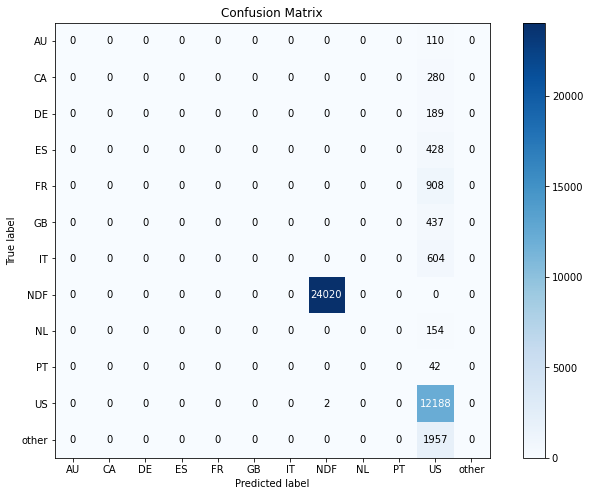

In [92]:
# Accuracy
print(f'Accuracy: {round(accuracy_score(y_test_nn, yhat_nn), 1) * 100}%')
print(f'Balanced Accuracy Score: {round(balanced_accuracy_score(y_test_nn, yhat_nn), 1) * 100}%')
print(f'Kappa Score: {cohen_kappa_score(y_test_nn, yhat_nn)}')

# Confusion Matrix
plot_confusion_matrix(y_test_nn, yhat_nn)
plt.show()

### Neural Network Cross-Validation

In [93]:
n_folds = 5
kfold = StratifiedKFold(n_folds, shuffle=True, random_state=seed)

y_train_f = pd.Series(ohe.inverse_transform(y_train).ravel())
accuracy_list = list()
balanced_accuracy_list = list()
kappa_score_list = list()

for train_ix, val_ix in kfold.split(x_train, y_train_f):
    # Data
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train_f.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train_f.iloc[val_ix]
    
    # Model definition
    model = models.Sequential()
    model.add(layers.Dense(128, input_dim=x_train_fold.shape[1], activation='relu'))
    model.add(layers.Dense(12, activation='softmax'))
    
    # model compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # OneHotEncoder
    y_train_fold = ohe.fit_transform(y_train_fold.values.reshape(-1, 1)).toarray()
    # Train
    model.fit(x_train_fold, y_train_fold, epochs=100, verbose=0)
    
    # Prediction
    pred_nn = model.predict(x_val_fold)
    
    # Invert prediction
    yhat_nn = ohe.inverse_transform(pred_nn).flatten()
    
    # Prediction prepare
    y_test_nn = y_val_fold.to_numpy().flatten()
    
    #Evaluation
    ac, bc, ks = model_evaluation_cv(y_test_nn, yhat_nn)
    accuracy_list.append(ac)
    balanced_accuracy_list.append(bc)
    kappa_score_list.append(ks)
    
print(f'Accuracy Score: {round(np.mean(accuracy_list), 2)} ± {round(np.std(accuracy_list), 2)}')
print(f'Balanced Accuracy Score: {round(np.mean(balanced_accuracy_list), 2)} ± {round(np.std(balanced_accuracy_list), 2)}')
print(f'Kappa Score: {round(np.mean(kappa_score_list), 4)} ± {round(np.std(kappa_score_list), 4)}')

2021-12-21 16:58:12.258953: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 158662800 exceeds 10% of free system memory.
2021-12-21 17:02:49.683279: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 158662800 exceeds 10% of free system memory.
2021-12-21 17:07:28.652975: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 158662800 exceeds 10% of free system memory.
2021-12-21 17:11:55.028490: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 158662800 exceeds 10% of free system memory.


Accuracy Score: 0.87 ± 0.0
Balanced Accuracy Score: 0.17 ± 0.0
Kappa Score: 0.766 ± 0.0003


## Data Output

# Model Performance

# Deploy